<a href="https://colab.research.google.com/github/asampat3090/musicalai/blob/main/_3_MIDI_representation_and_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIDI Representations and AI

Computer-generated MIDI has been a goal ever since the protocol was invented in 1983. The first MIDI sequencer was created in 1984 and the first MIDI composition was created in 1985. Sequential modeling has also come a long way since then. In order to investigate sequential models with MIDI, we'll focus on MIDI file representations, how it works and talk about input formats for some AI models that attempt to generate MIDI compositions. In subsequent posts we will build toward training our own sequential model to generate MIDI compositions (something akin to some of the models provided by [Magenta Studio](https://magenta.tensorflow.org/studio/))

As musicians working within a digital audio workstation (DAW) like [Ableton Live](https://www.ableton.com/en/live/), FL Studio, Garageband, Sony Acid or Logic Pro, we often work with audio and MIDI tracks together. MIDI files are represented as discrete tones in a spectrum, onto which a sound is attached to each note. We can represent percussion, melodies and everything in between with these notes. MIDI has also been one of the first places where automation and music generation made its mark. First, let's walk through what a MIDI file looks like.

## MIDI File Breakdown

What is a MIDI file anyways? It is a binary file that contains a sequence of MIDI messages. MIDI messages are instructions that tell a MIDI device (like a synthesizer) what to do. MIDI messages can be things like "play this note at this volume" or "change the pitch bend to this value". MIDI files are made up a header and a body. The header contains meta information and the body contains the data.

For our exploration, we'll use an example MIDI file representing the monophonic chorus of the song "Roja" by "A.R. Rahman" as an example. The MIDI file is from the TheoryTab dataset (and IMO is not a great rendition of the original song but hopefully good enough to recognize and to explore MIDI files :)

In [4]:
# If using Google Colab, download the MIDI file from Github and save it in the current directory and set the path
!wget -O roja-ar-rahman-melody.mid https://raw.githubusercontent.com/asampat3090/musicalai/dev/test-data/roja-ar-rahman-melody.mid
local_datapath_midi = 'roja-ar-rahman-melody.mid'

--2023-09-14 05:25:28--  https://raw.githubusercontent.com/asampat3090/musicalai/dev/test-data/roja-ar-rahman-melody.mid
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1212 (1.2K) [audio/midi]
Saving to: ‘roja-ar-rahman-melody.mid’

roja-ar-rahman-melo 100%[===================>]   1.18K  --.-KB/s    in 0s      

2023-09-14 05:25:29 (88.8 MB/s) - ‘roja-ar-rahman-melody.mid’ saved [1212/1212]



In [1]:
# If cloning the Github repo, set the path direct to the test-data
local_datapath_midi = 'test-data/roja-ar-rahman-melody.mid'

Let's see what the raw binary file looks like when we open it in VSCode...here's what the first few messages in the file.

```MThd     �MTrk  ! �Q	� �X �Y  �4_4_m_5_�@�	11_11__5_�@�4_4_m_5_�@�	11_11__5_�@�4_4__5_�@�9_9__5_�@�```

Needless to say, these are gibberish to us and it isn't important to understand the byte encodings to use it (though if you're interested in the format and byte representations more info here: https://www.cs.cmu.edu/~music/cmsip/readings/MIDI%20tutorial%20for%20programmers.html or http://www.music.mcgill.ca/~ich/classes/mumt306/StandardMIDIfileformat.html#BM2_2).

For us, we just need to know that MIDI files are split into headers and tracks. The header contain the file format, ticks per beat and the number of tracks. The file format is either 0, 1 or 2. Format 0 means that there is only one track. Format 1 means that there are multiple tracks. Format 2 means that there are multiple tracks but that each track is independent of the others. The tracks contain the MIDI events (aka messages) - musical events and meta events.

Let's use a library to parse the MIDI file and see what the file contents look like section-by-section. The [Mido](https://mido.readthedocs.io/en/latest/) library does a great job parsing the MIDI messages while maintaining the message structure, so we'll start there.

In [5]:
!pip install mido
from mido import MidiFile

In [6]:
# Adapted from tutorial: https://www.twilio.com/blog/working-with-midi-data-in-python-using-mido
mido_mid = MidiFile(local_datapath_midi, clip=True)
print(mido_mid)

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=631579, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='E', time=0),
    MetaMessage('marker', text='4_4_m_5_', time=0),
    MetaMessage('marker', text='11_11__5_', time=960),
    MetaMessage('marker', text='4_4_m_5_', time=960),
    MetaMessage('marker', text='11_11__5_', time=960),
    MetaMessage('marker', text='4_4__5_', time=960),
    MetaMessage('marker', text='9_9__5_', time=960),
    MetaMessage('marker', text='11_11__5_', time=960),
    MetaMessage('marker', text='4_4_m_5_', time=1920),
    MetaMessage('marker', text='11_11__5_', time=960),
    MetaMessage('marker', text='4_4_m_5_', time=960),
    MetaMessage('marker', text='11_11__5_', time=960),
    MetaMessage('marker', text='4_4_m_5_', time=960),
    MetaMessage('marker', text='9_9__5_', time=960),
    MetaMes

### MIDI File Header

Let's start by looking at the header of the MIDI file which is included as attributes in the `mido` file object printed above. We will ignore the `tracks` for now, and revisit that in the next section. In particular,

```python
MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=631579, time=0),...
```

`type` indicates the format of the MIDI file as discussed above (i.e. 0,1,2), `ticks_per_beat` indicates the number of ticks per beat (i.e. the resolution of the MIDI file) and `tracks` is a list of `MidiTrack` objects. The header byte info contains the number of tracks, though when interpreted by `mido` that is consolidated into the `tracks` variable.


#### Ticks
Time in MIDI messages are all relative and associated with ticks. Ticks are the smallest unit of time in MIDI. The number of ticks per quarter note is defined in the header of the MIDI file (`480` for our file). Ticks are important becasue they are how time is denoted in MIDI messages. In particular, `time` is denoted in the number of ticks *after* the previous message to execute the action specified in the message.

For example, if we have the following two messages:
```python
Message('note_on', channel=0, note=64, velocity=80, time=0),
Message('note_on', channel=0, note=64, velocity=0, time=480)
```

The second message will be executed `480` ticks after the first message and in this case the note at pitch `64` will be turned off (since the velocity is `0`) after 480 ticks or 1 quarter note. A `time` of `0` indicates the message should be executed immediately or simulataneously with the previous message. For future reference, for `mido` file objects you can use the `ticks_per_beat` to get the number of ticks per quarter note. Later we can use this to convert to seconds once we know the tempo of the song.

In [ ]:
print(mido_mid.ticks_per_beat)

480


### Tracks

A MIDI file can have multiple tracks like ours. The `MidiTrack` is a list of messages, which can be meta (i.e. related to metadata) or musical messages. `MetaMessage`'s have their own format, but do have a `type` which determines the other attributes of the message.

#### Meta Tracks

Although our simple melody track has 1 track of notes, there are two in this MIDI file because the first includes only relevant metadata and no musical messages. Let's delve into the first `MidiTrack`.

In [ ]:
print(mido_mid.tracks[0][0])

MetaMessage('set_tempo', tempo=631579, time=0)


This is a starting messages or Meta message which occurs simultaneously with a previous event - i.e. `time=0` (of which there is none) that sets the tempo at 631579 microseconds / quarter note. This translates to 60000000/631579 ~ 95 quarter notes per minute or equivalently 95 BPM (beats per minute). Many of the meta messages have `time=0` since time is irrelevant, though we'll go over an exception next.

With this tempo information we can now relate ticks to seconds. `480` ticks = 1 quarter note = 631579 microseconds = 0.631579 seconds => 1 tick = 0.0013158 seconds => ~45600 ticks / minute. While musicians often ignore this while composing or creating (i.e. beats matter more than time), this is useful to keep track of when converting this to audio or other formats. More info about the relationship between BPM (beats per minute), PPQN, MIDI Clock and SMPTE (time) can be found here:  http://midi.teragonaudio.com/tech/midifile/ppqn.htm

Messages follow these and can have many actions, a full list can be found by the MIDI association: https://www.midi.org/specifications-old/item/table-1-summary-of-midi-message. Let's look at the next two.

In [ ]:
print(mido_mid.tracks[0][1])
print(mido_mid.tracks[0][2])

MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='E', time=0)


Time signature is a meta message that sets the time signature of the song. In this case, the time signature is 4/4 meaning 4 beats (numerator) of quarter (1/4) notes (denominator).

The next message is a key signature message signifying E major. While this doesn't affect reading the file, when transposing a track in a Digital Audio Workstation it is helpful to know this. For example, if I were transposing the track to F major, I would need to transpose the notes up by 1 semitone (aka half step). Let's move on to the next one.

In [ ]:
print(mido_mid.tracks[0][3])

MetaMessage('marker', text='4_4_m_5_', time=0)


This meta message is a "marker" message which marks a point in the track with some string or `text` for some duration (much like a note). and has a text of "4_4_m_5_". If we look a few messages down we'll see a message `MetaMessage('marker', text='4_4_m_5_', time=960)` which is a similar marker executed 960 ticks or 2 quarter notes after the previous message `MetaMessage('marker', text='11_11__5_', time=960)`. Although I'm not sure what the text indicates here, it can be used to distinguish "verse" from "chorus" or "bridge" sections, or can be used to indicate a change in emotion, whatever the author wants. Either way, these WILL NOT affect the actual music. Next let's move on to the actual music in the next track!

#### Musical Tracks

Musical tracks will include mostly musical messages, but also will include some metadata. Let's look at the first meta message in the second `MidiTrack`.

In [ ]:
print(mido_mid.tracks[1][0])

MetaMessage('track_name', name='melody', time=0)


This really doesn't do much except assign a name to the track, note it also defaults to `time=0` since it has no concept of time.

In [ ]:
print(mido_mid.tracks[1][1])

program_change channel=0 program=0 time=0


Next is a `program_change` message indicates a change to `program=0` which might be a program for a MIDI instrument specified by `channel=0` (e.g. changing octaves for a synth). In our case, this doesn't do much.  Let's move on to the actual notes.

Each `Message` has a `type`, `time`, `note`, `velocity` and `channel`. The `type` indicates the action to be taken. The `time` is the number of ticks since the last message. The `note` is the index of the pitch from 0-127. `velocity` is the volume with which the note is played from 0-127. `channel` is the instrument to which it is routed.

Here are some more details:
* `type` can be `note_on`, `note_off`, `control_change`, `program_change`, `pitchwheel`, `sysex` or `unknown`. More details can be found here: https://www.midi.org/specifications-old/item/table-1-summary-of-midi-message
* `time` is an integer value called "tick" to synchronize the notes across tracks. To convert this to seconds or milliseconds, we can use the `ticks_per_beat` to convert to beats and then use tempo to convert it to seconds as we did above.
* `note` is a range from 0 to 127 where each integer corresponds to a note and frequency: [full table here](https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies).
* `velocity` is a range from 0 to 127 representing the amplitude or volume of note played (0 - silence, 127 - loudest).
* `channel` can be used to play multiple instruments at the same time (i.e. have multiple messages with different channels). In this case it is a simple melody piece so only 1 channel. For example, if we wanted to have a piano and a guitar playing at the same time, we could have two tracks with different `channel`'s and the same `time` and they would be played simultaneously.

Let's take a look at a couple of these messages and interpret them.


In [ ]:
print(mido_mid.tracks[1][2])
print(mido_mid.tracks[1][3])

note_on channel=0 note=64 velocity=80 time=0
note_on channel=0 note=64 velocity=0 time=480


The first two messages correspond to a "start" / "end" of the first quarter note. Rather than using a `note_off` message, this uses two `note_on` of the same pitch 64 (E3) but offset by 480 ticks (1 quarter note) with velocity 80 for the first to trigger the note and to trigger the note to be silent after 1 quarter note. A `note_on` message with velocity 0 is equivalent to a `note_off` message. This entire melody uses all `note_on` messages, but using the `note_off` message is also common.

## MIDI Models and Input Formats

If we look at some of the core papers looking at MIDI generation there bave been a number in the past few years - I won't try to be completely comprehensive here but I will note some of the important ones. The most notable ones in ~chronological order are (and coincidently though unsurprisingly grouped by models which correspond to the most popular types of models at the time):

***RNN-Based***
* **MelodyRNN [Google Magenta] (Jul 2016)**: LSTM based model for MIDI inputs
  * Derivatives: DrumsRNN, ImprovRNN, PerformanceRNN, MusicRNN
* **DeepBach (Dec 2016)**: a Steerable Model for Bach Chorales Generation

***GAN-Based***
* **MidiNet (Mar 2017)** : Convolutional GAN-based sequential prediction of MIDI nodes with conditioning options for chord sequences and melody of previous bars
* **MuseGAN (~2017)** : GAN-based model for generating multi-track MIDI files

***VAE-Based***
* **MusicVAE [Google Magenta] (Mar 2018)**: Interpolate between two 16 bar midi notes for smoothness, realism and expression
  * Derivatives: GrooVAE

***Transformer-Based***
* **Music Transformer [Google Magenta] (Dec 2018)** : Transformer-based model for generating multi-track MIDI files
* **MuseNet (2019)** : GPT-2 based model for generating multi-track MIDI files

Most importantly, they all use some form of a sequence as an input for training and inference. What we'll focus on first, is the question: **what format do these models expect the input to be in?**

**NOTE: We are explicitly ignoring the question of preprocessing datasets (i.e. what format do datasets come in and how to transform them), which we will defer to the next post since it is important for training these sequence models above or creating our own to craft a training set which may include multiple sources that need to be standardized to a single input format. For now, we assume we have a MIDI file present as above and convert them to a format usable for training. We will also defer augmentation and other adjustments (e.g. transposition, tempo adjustments, etc.) to the next post where we'll discuss considerations for training the models.**

In [7]:
!pip install pypianoroll
!pip install pretty_midi

import pypianoroll
import pretty_midi
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=e8d9c760ddb86e3ee4df704e658230bcec1ab538c753f64211f73c645e40a498
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


### Binary Piano Roll Representations

The piano roll representation is a common way to represent music data.
It consists of a two-dimensional matrix where the rows represent time steps
and the columns represent pitches (and special symbols in certain variations). The entries of the matrix are often non-negative.

One example is when the entries are binary, indicating whether a note is played at a given time step and pitch.

X ∈ {0, 1}^(h×w) where `h` is the number of pitches and `w` is the number of time steps.

*NOTE: velocity and complex time signature differences are IGNORED in this version!*

Another variation on this form also considers the velocity of the note. In this case, the entries are integers in the range of 0-127 indicating the velocity of the note played at a given time step and pitch. In this first section, we will talk about the models that look at only the binary piano roll representation, but will revisit the velocity in the next section.

X ∈ [0,127]^(h×w)

NOTE: The number of pitches in a MIDI file is 128, however the dimension of `h` may be reduced to narrow the range of notes to a specific instrument (e.g. 88 keys in a piano) or can be expanded to include silence or rests (e.g. 129/130 or 89/90). The time steps also depend on the model and level of granularity desired. For coherence, many models filter inputs to 4/4 time signatures and use sixteenth notes as a single time step (16 steps / bar).  

For the RNN-Based, GAN-Based and VAE-Based models above, at some level all of these look at splitting the MIDI files into discrete time bars and ignoring the velocity. However they vary in how they split the bars and the granularity of notes they use.

***RNN-Based***
* **MelodyRNN**: "[60, -2, 60, -2, 67, -2, 67, -2]” (-2 = no event, -1=note-off event, 0-127 = note-on event for that MIDI pitch) for each track. 4/4 time signature with 16th notes as a single time step. Each bar has 16 time steps. Samples can be 2 bars or 16 bars.
* **DeepBach**: 4 tracks/rows (soprano, alto, tenor, bass) with 16 time steps per bar (16th notes) represented by strings for the 128 pitches `C1` to `G9` and a hold `__` (i.e. 129 total pitches), two additional rows are added with `0` or `1` to indicate fermata and the beat count (e.g. `1,2,3,4`)

***GAN-Based***
* **MidiNet**: piano roll representation in 4/4 time signature with 16th notes as a single time step. Each track is a new channel (e.g. CxHxW). Each sample is 1 bar and each value can be one of 128 MIDI pitches or silence resulting in a Cx129x16 matrix for each bar.
* **MuseGAN**: piano roll representation in 4/4 time signature with 16th notes as 6 time steps. That is each bar has 96 time steps. Each track is a new channel and each sample is 1 bar (e.g. CxHxW). Each value can be one of 128 MIDI pitches resulting in Cx128x96 matrix for each bar. The dimensions are rearranged to be 96x128xC.

***VAE-Based***
* **MusicVAE**: "[60, -2, 60, -2, 67, -2, 67, -2]” (-2 = no event, -1=note-off event, 0-127 = note-on event for that MIDI pitch) for each track. 4/4 time signature with 16th notes as a single time step. Each bar has 16 time steps. Samples can be 2 bars or 16 bars.

**Observations:**
* All of these models use 4/4 time signature and a 16th note or some subset of them as a time step. This is likely because it helps with standardization and structure of the data. For examples if we processed 6/8 or 5/4 time signatures and split them with the same time steps as 4/4, we would capture motifs that span bars which may not be consistent. And since the majority of pieces are 4/4, it is advantageous to use that time signature and discard others.
* All representations discard the velocity of the notes. This is likely because it is not as important for the melody and the models then not as sensitive to it, that is, there is less to learn. Velocity variations could also be added posthoc to make the outputs seem more realistic.
* Representations of the matrix are still highly variable and depends on the model, the DL library (TF, Pytorch, etc) and the application. We'll next explore code to transform midi files to all of these formats. For the above models we'll focus on the following 3 common formats which were most common:
   1. Compressed Piano Roll Representation w/ Pitch Indices (CxW): MelodyRNN, MusicVAE
   2. Compressed Piano Roll Representation w/ Note Names (CxW): DeepBach
   3. One/Multi-Hot Piano Roll Representations (CxHxW): MidiNet, MuseGAN

#### 1. Compressed Piano Roll Representation w/ Pitch Indices (CxW)

These representations are used commonly by the Google Magenta team across MelodyRNN and MusicVAE and represent each time step with an absolute pitch index `0-127` rather than a 1-hot or multi-hot encoding. Since it is can only represent 1 note per time step, the channels or `C` dimention enable multiple instruments or notes to be represented.

In [9]:
def midi_to_pitch_pianoroll(midi_file:str, resolution:int=24, program_num:int=0):
    ppr_mid = pypianoroll.read(midi_file, resolution=resolution)
    num_tracks = len(ppr_mid.tracks)
    # assume all tracks have the same # of time steps
    time_steps = ppr_mid.tracks[0].pianoroll.shape[0]
    result = np.ones((num_tracks, time_steps),dtype=int) * -2

    for i in range(len(ppr_mid.tracks)):
        for j in range(ppr_mid.tracks[i].pianoroll.shape[0]):
            if np.sum(ppr_mid.tracks[i].pianoroll[j,:]) > 0:
                note_ind = np.argmax(ppr_mid.tracks[i].pianoroll[j,:])
                result[i,j] = note_ind
    return result

test = midi_to_pitch_pianoroll(local_datapath_midi)
print(test.shape)
print(test[:,10:1000])


(1, 1680)
[[64 64 64 64 64 64 64 64 64 64 64 64 64 64 67 67 67 67 67 67 67 67 67 67
  67 67 67 67 67 67 67 67 67 67 67 67 67 67 66 66 66 66 66 66 66 66 66 66
  66 66 67 67 67 67 67 67 67 67 67 67 67 67 66 66 66 66 66 66 66 66 66 66
  66 66 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 64 64 64 64 64 64 64 64 64 64
  64 64 64 64 64 64 64 64 64 64 64 64 64 64 67 67 67 67 67 67 67 67 67 67
  67 67 67 67 67 67 67 67 67 67 67 67 67 67 66 66 66 66 66 66 66 66 66 66
  66 66 67 67 67 67 67 67 67 67 67 67 67 67 66 66 66 66 66 66 66 66 66 66
  66 66 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 64 64 64 64 64 64 64 64 64 64
  64 -2 64 64 64 64 64 64 64 64 64 64 64 64 68 68 68 68 68 68 68 68 68 68
  68 68 68 68 68 68 68 68 68 68 68 68 68 68 69 69 69 69 69 69 69 69 69 69
  69 -2 69 69 69 69 69 69 69 69 69 69 69 -2 71 71 71 71 71 71 71 71 71 71
  71 71 71 71 71 71 71 -2 69 69 69 69 69 -2 67 67 67 67 67 67 67 67 67 67
  67 67 67 67 67 67 67 67 67 67 67 67 67 67 66 66 66 66 66 66 66 66 66 66
  66 66 66 66 66 66 66 66 66

Note: we result in 1680 time steps for the 17.5 bars in the song. Each bar has 4 beats, so 70 beats altogether. 1680/70 = 24, meaning we have 24 time steps per beat. 24 is the defualt resolution for pypianoroll, but we can update that depending on the granularity desired. Since we use pypianoroll, we'll have the same time steps for subsequent representations. That is, our `W` dimension will be the same.

#### 2. Compressed Piano Roll Representation w/ Note Names (CxW)

Here we use a very similar approach to above, but convert the notes and like it is described in DeepBach, we use the `__` symbol for a hold where there are no notes playing.  

In [10]:
def midi_to_note_pianoroll(midi_file:str, resolution:int=24, program_num:int=0):
    ppr_mid = pypianoroll.read(midi_file, resolution=resolution)
    num_tracks = len(ppr_mid.tracks)
    # assume all tracks have the same # of time steps
    time_steps = ppr_mid.tracks[0].pianoroll.shape[0]
    result = []

    for i in range(len(ppr_mid.tracks)):
        track_vals = []
        for j in range(ppr_mid.tracks[i].pianoroll.shape[0]):
            if np.sum(ppr_mid.tracks[i].pianoroll[j,:]) > 0:
                note_ind = np.argmax(ppr_mid.tracks[i].pianoroll[j,:])
                track_vals.append(pretty_midi.note_number_to_name(note_ind))
            else:
                track_vals.append('__')
        result.append(track_vals)

    return np.array(result)

test = midi_to_note_pianoroll(local_datapath_midi)
print(test.shape)
print(test[:,10:1000])

(1, 1680)
[['E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4'
  'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4'
  'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'F#4' 'F#4' 'F#4'
  'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'G4' 'G4' 'G4'
  'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'F#4' 'F#4' 'F#4' 'F#4'
  'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' '__' '__' '__' '__'
  '__' '__' '__' '__' '__' '__' '__' '__' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4'
  'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4'
  'E4' 'E4' 'E4' 'E4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4'
  'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4'
  'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4'
  'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'G4' 'F#4' 'F#4'
  'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' 'F#4' '__' '__'
  '__' '__' '__' '__' '__' '__' '__' '__' '__' '__' 'E4'

#### 3. One/Multi-Hot Piano Roll Representations (CxHxW)

The one/multi-hot piano roll representation is the classic representation used by MidiNet and MuseGAN and ignore the velocity which means that the piano roll representation they adhere too is the binary one: X ∈ {0, 1}^(H×W).

Here the output of the piano roll will be a matrix with 128 rows to signify the 128 different pitch levels (note a piano only has 88). The columns will be the time steps. The values will be 1 or 0 to signify whether the note is played or not as a one-hot encoding.

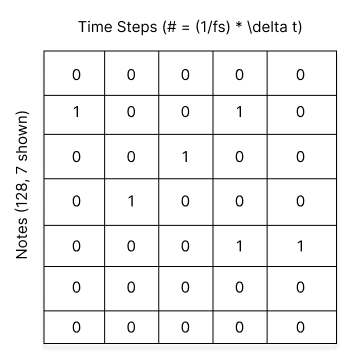

In [ ]:
%matplotlib inline
from IPython.display import Image
Image('images/piano-roll.png')

We can define a simple function to convert a MIDI file to this simple format. We'll use the `pretty_midi` library to parse the MIDI file and then use the `pypianoroll` library to convert it to a piano roll representation.

In [11]:
def midi_to_piano_roll(midi_path:str, resolution:int=24) -> np.ndarray:
    """Converts a MIDI file to a binary piano roll representation.
    More info about args: https://salu133445.github.io/pypianoroll/doc.html#pypianoroll.from_pretty_midi

    Args:
      midi_path (str): Path to the MIDI file.
      resolution (int): Number of ticks per beat (default: 24).

    Returns:
      np.ndarray: Binary piano roll representation of the MIDI file.

    Usage:
    > midi_to_piano_roll(midi_path, resolution=24)
    """
    ppr_midi = pypianoroll.read(midi_path, resolution=resolution)
    ppr_midi.binarize()
    piano_roll = ppr_midi.tracks[0].pianoroll.astype(int)
    piano_roll = np.swapaxes(piano_roll,0,1)
    return piano_roll

In [12]:
pr = midi_to_piano_roll(local_datapath_midi,resolution=24)
print(pr.shape)
print(pr[:,900]) # only look at 1 1-hot vector for 1 time step

(128, 1680)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Expressive Piano Roll & Language-Based Representations

Following in the footsteps of recent language models, transformer based models can use more expressive piano roll and language-based encodings to represent the MIDI files. In particular, language modeling has often used byte-pair encodings (BPE) to represent words as a sequence of bytes. This is a great way to represent words because it allows for a variable length encoding of words and allows for the model to learn sub-word representations.

Let's explore what the Transformer based models use to represent MIDI files.

***Transformer-Based***
* **Music Transformer (Google)**: Multiple formats for different datasets and experiments   
  - JS Chorales Bach: (similar to DeepBach) uses the following sequence of 4 voices (soprano, alto, tenor, bass) in 4/4 time in sixteenth note increments
    - ![bach chorales](https://github.com/asampat3090/musicalai/blob/main/images/music-transformer-bach-chorales.png?raw=1)
    - Inputs are serialized $S_1A_1T_1B_1S_2A_2T_2B_2$ and each token is represented as a one-hot vector → 128 x (WxC) where W is number of sixteenth notes and C is the number of channels - in this case 4 for each voice
  - Piano E Competition Dataset: [Ref: https://arxiv.org/pdf/1808.03715.pdf] → Use a set of sequence events like the following.
    - ![piano competition](https://github.com/asampat3090/musicalai/blob/main/images/music-transformer-sequence.png?raw=1)
    - Overall the total number of sequences are eventually represented as a sequence of 1-hot vectors representing each of the 388 possible events -> 388 x T where T is the the number of 10ms increments in the sample. This representation for the Piano competition dataset is discussed in section 6.1 of [this paper](https://link.springer.com/article/10.1007/s00521-018-3758-9).
      - 128 `NOTE-ON` events: one for each of the 128 MIDI pitches. Each one starts a new note.
      - 128 `NOTE-OFF` events: one for each of the 128 MIDI pitches. Each one releases a note.
      - 100 `TIME-SHIFT` events: each one moves the time step forward by increments of 10 ms up to 1 s.
      - 32 `VELOCITY` events: each one changes the velocity applied to all subsequent notes (until the next velocity event).
* **MuseNet (OpenAI)**:  `bach piano_strings start tempo90 piano:v72:G1 piano:v72:G2 piano:v72:B4 piano:v72:D4 violin:v80:G4 piano:v72:G4 piano:v72:B5 piano:v72:D5 wait:12 piano:v0:B5 wait:5 piano:v72:D5 wait:12 piano:v0:D5 wait:4 piano:v0:G1 piano:v0:G2 piano:v0:B4 piano:v0:D4 violin:v0:G4 piano:v0:G4 wait:1 piano:v72:G5 wait:12 piano:v0:G5 wait:5 piano:v72:D5 wait:12 piano:v0:D5 wait:5 piano:v72:B5 wait:12`

Observations:
* Transformer-based model representations are more flexible and leverage expressivity (velocity) and polyphonicity.
* Transformer-based model representations only require sequential processing but are open to using one-hot vectors (i.e. pianoroll representations) as well as language based ones (i.e. MuseNet).
* Representations can be broken down in the following ways:
  1.  One-hot Binary Piano Roll Representations (128x(WxC)): Music Transformer (JS Chorales Bach)
  2.  One-hot Expressive Piano Roll Representations (388xW): Music Transformer (Piano E Competition)
  3.  Sequential Encoding & Tokenization (???): MuseNet

#### 1. One-hot Binary Piano Roll Representations (128x(WxC))

This is not too dissimilar from our previous work on representations except that it allows for combining the channels from different instruments into 1 dimension which means that W (the time dimension) and C (the channel dimension) are combined. It also means that an encoder and decoder must be present to identify these differences. Given we only have 1 track, the output will not be any different for our trial MIDI file, however we define a function that would work for multiple tracks. Our second dimention is WxC (in our case 1680x1=1680)

In [13]:
def midi_to_binary_pianoroll_multi_flat(midi_file:str, resolution:int=24):
    ppr_mid = pypianoroll.read(midi_file, resolution=resolution)
    num_tracks = len(ppr_mid.tracks)
    # assume all tracks have the same # of time steps
    time_steps = ppr_mid.tracks[0].pianoroll.shape[0] # W
    result = np.zeros((num_tracks*time_steps, 128),dtype=int) # (CxW, H)
    for time_id in range(time_steps):
        for track_id in range(num_tracks):
            if ppr_mid.tracks[track_id].pianoroll[time_id,:].any():
                note_ind = np.argmax(ppr_mid.tracks[track_id].pianoroll[time_id,:])
                result[(time_id*num_tracks) + track_id, note_ind] = 1
    result = np.swapaxes(result,0,1)
    return result

result = midi_to_binary_pianoroll_multi_flat(local_datapath_midi)
print(result.shape)
print(result[:,900])

(128, 1680)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### 2. One-hot Expressive Representation (388xW) - 1 Track

This is a unique approach because it takes into account timing and velocity. It is also a one-hot representation, but it is not a piano roll representation. Instead it is a sequence of events that are encoded as one-hot vectors. To recap, the events we care about are:
- 128 `NOTE-ON` events: one for each of the 128 MIDI pitches. Each one starts a new note.
- 128 `NOTE-OFF` events: one for each of the 128 MIDI pitches. Each one releases a note. `NOTE-ON` with velocity 0 is equivalent to `NOTE-OFF`.
- 100 `TIME-SHIFT` events: each one moves the time step forward by increments of 10 ms up to 1 s.
- 32 `VELOCITY` events: each one changes the velocity applied to all subsequent notes (until the next velocity event).

Our MIDI file is fairly standard in that it has just 1 velocity across all monophonic notes. Therefore, we will see very standard representations for this. However, if we had a more expressive MIDI file with multiple instruments and velocities, we would see more `VELOCITY` events. You might have noticed that we could add more events here to the vocabulary to expand the 1-hot representation to include other musical events like `TEMPO` or `KEY_SIGNATURE` or `TIME_SIGNATURE` or `PROGRAM_CHANGE` or `CONTROL_CHANGE` (e.g. pedal, levers,etc.) or `PITCH_WHEEL`, etc. However, we'll leave that for a future post. These are the events used in Musical Transformer.  

In [16]:
import mido

def midi_to_expressive_rep(midi_file:str):
    """Converts a MIDI file to an expanded representation. Assume 1 track"""
    # USE MIDO to convert these to a list of note onsets and offsets
    mido_mid = MidiFile(midi_file, clip=True)
    tempo = mido_mid.tracks[0][0].tempo
    ticks_per_beat = mido_mid.ticks_per_beat
    curr_velocity = 0
    # assume we use the 388 different representations from Music Transformer
    result = np.empty([0,388])

    for msg in mido_mid.tracks[1]:
        if msg.type == 'note_on' or msg.type == 'note_off':
            note_ind = msg.note
            note_time = msg.time
            note_velocity = msg.velocity
            if note_time > 0:
                del_t_sec = mido.tick2second(note_time, ticks_per_beat, tempo)
                del_t_ms = del_t_sec*1000
                time_ind = round(del_t_ms/10)
                if time_ind > 99: # if the time step is greater than 100 ms, set it to 100 ms
                    # add extra time step
                    new_step = np.zeros((1,388))
                    new_step[0,256+99] = 1 # set max time
                    result = np.append(result, new_step, axis=0)
                    # set time_ind to remainder
                    time_ind = 100-time_ind
                # add the time step
                new_step = np.zeros((1,388))
                new_step[0,256+time_ind] = 1 # set time
                result = np.append(result, new_step, axis=0)
        if msg.type == 'note_on' and msg.velocity > 0:
            note_ind = msg.note
            note_time = msg.time
            note_velocity = msg.velocity
            if note_velocity != curr_velocity:
                # add set velocity
                new_step = np.zeros((1,388))
                velocity_ind = round((float(note_velocity)/128)*32)
                new_step[0,356+velocity_ind] = 1 # set velocity
                result = np.append(result, new_step, axis=0)
                # update the curr_velocity
                curr_velocity = note_velocity
            # add the note on
            new_step = np.zeros((1,388))
            new_step[0,note_ind] = 1
            result = np.append(result, new_step, axis=0)
        if msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            # add the note off message
            new_step = np.zeros((1,388))
            new_step[0,128+note_ind] = 1
            result = np.append(result, new_step, axis=0)
    result = np.swapaxes(result,0,1)
    return result

result = midi_to_expressive_rep(local_datapath_midi)
print(result.shape)
print(result[:,1])

(388, 281)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

#### 3. Sequential Encoding & Tokenization (???)

While MuseNet was one of the most interesting applications of MIDI-based music generation using GPT-2 and Sparse Transformers, the [blog post](https://openai.com/research/musenet) was "sparse" in its explanation of the encoding. Since the tokens were not explained I am not entirely sure how to convert the language sequence provided to discrete tokens to train a model (e.g. byte-pair encoding). We'll use some combination of expressive representations in 2 and 3 to train our own transformer-based model in a future post.

For now, we'll write some code to convert a MIDI file to a format similar to the one mentioned in their blog post - all timings in ticks and all notes in MIDI pitch values.:

`bach piano_strings start tempo90 piano:v72:G1 piano:v72:G2 piano:v72:B4 piano:v72:D4 violin:v80:G4 piano:v72:G4 piano:v72:B5 piano:v72:D5 wait:12 piano:v0:B5 wait:5 piano:v72:D5 wait:12 piano:v0:D5 wait:4 piano:v0:G1 piano:v0:G2 piano:v0:B4 piano:v0:D4 violin:v0:G4 piano:v0:G4 wait:1 piano:v72:G5 wait:12 piano:v0:G5 wait:5 piano:v72:D5 wait:12 piano:v0:D5 wait:5 piano:v72:B5 wait:12`

In [17]:
def midi_to_sequence(midi_file:str):
    """Converts a MIDI file a sequence. Assume 1 track"""
    # USE MIDO to convert these to a list of note onsets and offsets
    mido_mid = MidiFile(midi_file, clip=True)
    tempo = mido_mid.tracks[0][0].tempo # assume tempo same for all tracks
    tempo = round(mido.tempo2bpm(tempo)) # convert to bpm
    instrument = "piano"
    # assume we use the 388 different representations from Music Transformer
    result = ""
    result += mido_mid.tracks[1].name # add track name
    result += " " + instrument # add instrument
    result += " start" # add start token
    result += " tempo" + str(tempo) # add tempo

    # loop through track and add in the notes
    for msg in mido_mid.tracks[1]:
        if msg.type == 'note_on' or msg.type == 'note_off':
            note_ind = msg.note
            note_time = msg.time
            note_velocity = msg.velocity
            # add wait time before note
            if note_time > 0:
                result += " wait:" + str(note_time)
            # add the note
            result += " " + instrument + ":v" + str(note_velocity) + ":" + pretty_midi.note_number_to_name(note_ind)
    return result

In [18]:
result =  midi_to_sequence(local_datapath_midi)
print(result)

melody piano start tempo95 piano:v80:E4 wait:480 piano:v0:E4 piano:v80:G4 wait:480 piano:v80:F#4 piano:v0:G4 wait:240 piano:v0:F#4 piano:v80:G4 wait:240 piano:v80:F#4 piano:v0:G4 wait:240 piano:v0:F#4 wait:240 piano:v80:E4 wait:480 piano:v0:E4 piano:v80:G4 wait:480 piano:v80:F#4 piano:v0:G4 wait:240 piano:v0:F#4 piano:v80:G4 wait:240 piano:v80:F#4 piano:v0:G4 wait:240 piano:v0:F#4 wait:240 piano:v80:E4 wait:240 piano:v0:E4 piano:v80:E4 wait:240 piano:v0:E4 piano:v80:G#4 wait:480 piano:v0:G#4 piano:v80:A4 wait:240 piano:v0:A4 piano:v80:A4 wait:240 piano:v0:A4 piano:v80:B4 wait:360 piano:v80:A4 piano:v0:B4 wait:120 piano:v80:G4 piano:v0:A4 wait:480 piano:v80:F#4 piano:v0:G4 wait:480 piano:v0:F#4 wait:960 piano:v80:E4 wait:480 piano:v0:E4 piano:v80:G4 wait:360 piano:v0:G4 piano:v80:G4 wait:120 piano:v80:F#4 piano:v0:G4 wait:240 piano:v0:F#4 piano:v80:G4 wait:240 piano:v80:F#4 piano:v0:G4 wait:240 piano:v0:F#4 wait:240 piano:v80:E4 wait:480 piano:v0:E4 piano:v80:G4 wait:360 piano:v0:G4 pia

# Conclusions

The transformer based models are the most recent and have shown to be the most expressive - the sequences used leverage velocity, polyphonicity and dynamics of MIDI instruments and have shown to better represent long term structure (unsurprising given similar results in language).

We'll take a deeper dive into those because they are flexible and we can experiment with many of the latest architectures being used for language modeling. We can choose to use the same encodings as the models above or we can experiment with other encodings that express similar or even additional information.